In [ ]:
from scipy.sparse.linalg import minres, LinearOperator
import numpy as np 

global d1,d2,d3

def matvec(x):
    global d1,d2,d3
    res = np.zeros_like(x)
    st = d1[0].shape[0]
    for i in range(1,len(d2)-1):
        res[st*i:st*(i+1)] = d1[i-1].dot(x[st*(i-1):st*(i)]) + d2[i].dot(x[st*i:st*(i+1)]) + d3[i].dot(x[st*(i+1):st*(i+2)])
    res[:st] = d2[0].dot(x[:st])+d3[0].dot(x[st:2*st])
    res[-st:] = d1[-1].dot(x[-2*st:-st])+d2[-1].dot(x[-st:])
    return res

x= np.ndarray(shape=(100010,1),dtype=np.float64)
d1 = np.random.rand(10000,10,10)
d2 = np.random.rand(10000,10,10)
d3 = np.random.rand(10001,10,10)
lo = LinearOperator(shape=(len(x),len(x)),matvec=matvec )
y = matvec(x)
x,er = minres(lo,y)
print x.shape

err = ((matvec(x)-y)**2).mean()
print err


# Block Thomas algorithm

(link: http://www4.ncsu.edu/eos/users/w/white/www/white/ma580/chap2.5.PDF)

$$M = \begin{pmatrix} A_1 & C_1 & 0 &0&... \\ B_2 & A_2 & C_2 & 0& ... \\ 0 & B_3 &A_3&C_2&0 \\ ...&...&...&...&...\end{pmatrix}$$
$$d  =Mx$$

### solver
$$\alpha_1 = A_1^{-1}$$
$$\gamma_1 = \alpha_1^{-1}C_1$$
$$Y_0 = \alpha_1^{-1}d_1$$
for i from 2 to N:

$\quad b = Mx$

$\quad \alpha_i = A_i-B_i\gamma_{i-1}$

$\quad \gamma_i = \alpha_i^{-1}C_i$

$\quad Y_i = \alpha_i^{-1}(d_i-B_iY_{i-1}$

$$x_N = Y_N$$
for i from N-1 to 1:

$\quad x_i = Y_i-\gamma_ix_{i+1}$

In [16]:
from numpy.linalg import inv
import numpy as np


def matvec(A,B,C,x):
    xN = x.shape[1]
    res = x.copy()
    for i in range(1,xN-1):
        res[:,i] = A[:,:,i].dot(x[:,i])+B[:,:,i-1].dot(x[:,i-1])+C[:,:,i].dot(x[:,i+1])
    res[:,0] = A[:,:,0].dot(x[:,0])+C[:,:,0].dot(x[:,1])
    res[:,-1] = B[:,:,-1].dot(x[:,-2])+A[:,:,-1].dot(x[:,-1])
    return res
    

def solve_linear(A,B,C,d):
    x = np.empty(d.shape,dtype= np.float64)
    xN = x.shape[1]
    Y = np.empty(d.shape,dtype= np.float64)
    gamma = np.empty(C.shape,dtype= np.float64)
    ialpha= np.linalg.inv(A[:,:,0])
    gamma[:,:,0] = ialpha.dot(C[:,:,0])
    Y[:,0] = ialpha.dot(d[:,0])
    for i in range(1,xN-1):
        ialpha = np.linalg.inv(A[:,:,i]-B[:,:,i-1].dot(gamma[:,:,i-1]))
        gamma[:,:,i] = ialpha.dot(C[:,:,i])
        Y[:,i] = ialpha.dot(d[:,i]-B[:,:,i-1].dot(Y[:,i-1]))

    ialpha = np.linalg.inv(A[:,:,xN-1]-B[:,:,xN-2].dot(gamma[:,:,xN-2]))
    Y[:,xN-1] = ialpha.dot(d[:,xN-1]-B[:,:,xN-2].dot(Y[:,xN-2]))
    x[:,xN-1] = Y[:,xN-1]
    for i in reversed(range(xN-1)):
        x[:,i] = Y[:,i]-gamma[:,:,i].dot(x[:,i+1])
    return x



## Time test

In [17]:
import matplotlib.pyplot as plt
from time import time
%matplotlib inline


N = 100000
M = 5
x= np.random.rand(M,N).astype(np.float64)
B = np.random.rand(M,M,N-1)
C = np.random.rand(M,M,N-1)
for i in range(N-1):
    B[:,:,i]+= np.eye(M,M)*2
    C[:,:,i]+= np.eye(M,M)*2
A = np.random.rand(M,M,N)
for i in range(N):
    A[:,:,i]+= np.eye(M,M)*2
d = matvec(A,B,C,x)
print x.shape

%timeit x1 = solve_linear(A,B,C,d)

(5L, 100000L)
1 loop, best of 3: 10.3 s per loop


## Accuracy test

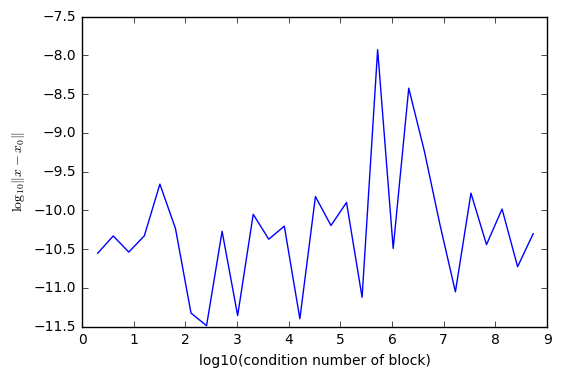

In [18]:
def generate_mat(M,cond):
    b = np.random.rand(M,M)
    U,s,V = np.linalg.svd(b)
    s[0] = s[-1]*cond
    return b

def thomas_accuracy_test():
    errors = []
    conds = []
    for k in range(1,30):
        N = 1000
        M = 5
        cond = 2**k
        x= np.random.rand(M,N).astype(np.float64)
        B = np.random.rand(M,M,N-1)
        C = np.random.rand(M,M,N-1)
        b = np.random.rand(M,M)
        U,s,V = np.linalg.svd(b)
        s[0] = s[-1]*cond
        b = U.dot(np.diag(s).dot(V.T))
        for i in range(N-1):
            B[:,:,i] = generate_mat(M,cond)
            C[:,:,i] = generate_mat(M,cond)
        A = np.random.rand(M,M,N)
        for i in range(N):
            A[:,:,i] = generate_mat(M,cond)
        d = matvec(A,B,C,x)
        x1 = solve_linear(A,B,C,d)
        errors.append(np.abs(x-x1).mean())
        conds.append(cond)

    plt.plot(np.log10(conds),np.log10(errors))
    plt.xlabel('log10(condition number of block)')
    plt.ylabel('$ \\log_{10}\\|x-x_0\\| $')
    plt.show()
    
thomas_accuracy_test()